In [1]:
#Importing the required Libraries
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.9.1


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators:  1


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
fake_df = pd.read_csv('Fake.csv')
real_df = pd.read_csv('True.csv')

In [6]:
fake_df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [7]:
fake_df.isnull().sum()
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [8]:
fake_df.subject.unique()
real_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [9]:
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

In [10]:
fake_df['class'] = 0 
real_df['class'] = 1

Text(0, 0.5, '# of News Articles')

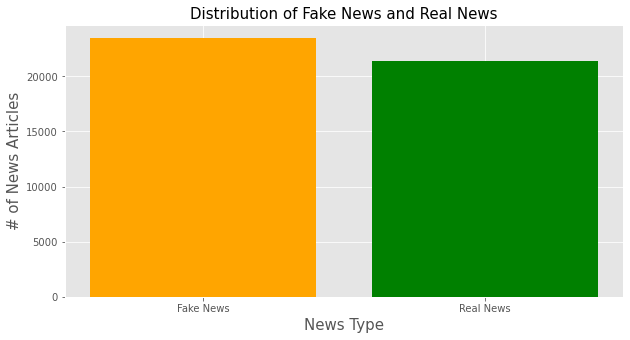

In [11]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)

In [12]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [13]:
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

In [14]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [15]:
X_test

32213    In circuitous speech, Trump touts VP pick Penc...
39740    Bomb attack kills one Bahraini policeman, woun...
40650    Seoul considers unilateral sanctions against N...
28194    House clears way for debate on Trump-backed he...
10034    About Time! Christian Group Sues Amazon and SP...
                               ...                        
6072      The PGA Just Gave Donald Trump A Big Middle F...
18028    MSNBC REPORTER SHOCKED After Leftists Call For...
5579      McConnell Just ADMITTED The NRA Must Approve ...
29761    Factbox: Trump meets with Boeing chief, others...
1148      NUTJOB Missouri State Rep Beheads Live Chicke...
Name: text, Length: 8980, dtype: object

In [16]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [17]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [18]:
X_train[0]

'time to go 84 yr old supreme court justice ginsberg tells college audience 3 term male u s senator is a female video justice ruth bader ginsburg erroneously labeled south carolina sen lindsey graham as one of the women of the senate on monday ginsburg s misstatement came in her remarks upon accepting an allegheny college award given to her and the late justice antonin scalia for civility in public life hours after justice neil gorsuch was sworn in to replace scalia ginsburg took to the podium in calling on lawmakers to work together but mistakenly identified south carolina s senior senator as a woman i thought back to the 1993 confirmation of my nomination to the court the hearing was altogether civil the vote was 96 to 3 for justice scalia the vote was unanimous ginsburg said let s hope members of congress the members that allegheny college has already honored vice president joe biden and senator john mccain the women of the senate senators dianne feinstein and lindsey graham let s h

In [19]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [20]:
y_train

18839    0
13614    0
37215    1
39032    1
10143    0
        ..
5294     0
1726     0
35653    1
25720    1
28947    1
Name: class, Length: 35918, dtype: int64

In [21]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [22]:
X_train[0][0]

98

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [32]:
# We are going to use early stop, which stops when the validation loss no longer improve.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=2,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/2
1078/1078 [==============================] - 100s 86ms/step - loss: 0.0615 - accuracy: 0.9843 - val_loss: 0.0587 - val_accuracy: 0.9777
Epoch 2/2
1078/1078 [==============================] - 95s 88ms/step - loss: 0.0334 - accuracy: 0.9916 - val_loss: 0.0459 - val_accuracy: 0.9861


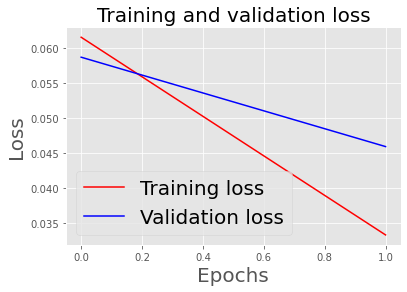

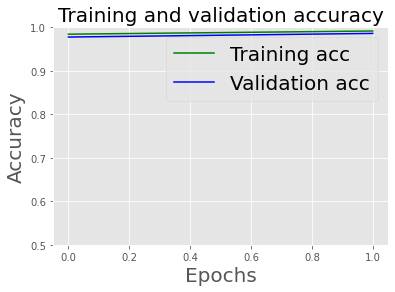

In [33]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [35]:
model.save('ML_LSTM.model')

INFO:tensorflow:Assets written to: ML_LSTM.model\assets


INFO:tensorflow:Assets written to: ML_LSTM.model\assets


In [34]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 9s 33ms/step - loss: 0.0441 - accuracy: 0.9871


[0.0441465899348259, 0.9870824217796326]

In [37]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

281/281 [==============================] - 10s 31ms/step


In [38]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9870824053452116
Precision on testing set: 0.983788791106994
Recall on testing set: 0.9892873777363763


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

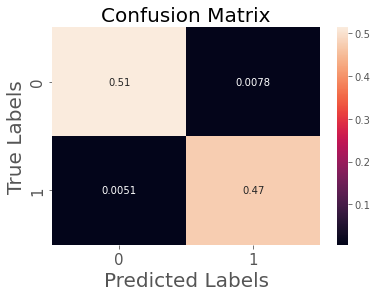

In [39]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(6,4))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

In [40]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 32)


In [41]:
word_index = list(tokenizer.word_index.keys())
word_index = word_index[:max_vocab-1]